# Test simple RNN, LSTM and GRU models

### load data

In [1]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf
import tensorflow.keras as K

from tensorflow.keras.utils import plot_model
from utils import get_train_data, BASE_DIR
from example import LABELS

2022-03-04 09:41:05.628995: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


BASE_DIR: /home/andrew/Рабочий стол/Punch_DL


In [2]:
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
if sys.platform == 'linux':
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        print('GPU detected')
        
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

    tf.config.experimental.set_virtual_device_configuration(
        physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

GPU detected


2022-03-04 09:41:09.877323: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-03-04 09:41:09.951430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 09:41:09.951822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2022-03-04 09:41:09.951849: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-03-04 09:41:09.983211: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-03-04 09:41:10.001171: I tensorflow/stream_executor/pla

In [38]:
X_train, y_train, X_val, y_val = get_train_data(skip_midpoints=True, all_labels=True)

validation files
i1_hook_2
id4_hook_2
id0_jab_2
id2_jab_2
id4_jab_2
id2_uper_2
id3_uper_2
id4_uper_2

id1_hook_2 | reversed: False | data shape: (792, 34)
--------------------
id3_hook_1 | reversed: False | data shape: (1461, 34)
--------------------
id3_hook_2 | reversed: False | data shape: (1297, 34)
--------------------
id4_hook_1 | reversed: False | data shape: (1054, 34)
--------------------
id4_hook_2 | reversed: False | data shape: (1059, 34)
--------------------
id1_hook_1 | reversed: False | data shape: (858, 34)
--------------------
id2_hook_1 | reversed: False | data shape: (1013, 34)
--------------------
id0_hook_2 | reversed: False | data shape: (1051, 34)
--------------------
id0_hook_1 | reversed: False | data shape: (1100, 34)
--------------------
id2_hook_2 | reversed: False | data shape: (1041, 34)
--------------------
id3_jab_2 | reversed: False | data shape: (1164, 34)
--------------------
id4_jab_1 | reversed: False | data shape: (911, 34)
--------------------
id2

In [39]:
print(f'Validation data percent: {y_val.shape[0] / (y_train.shape[0] + y_val.shape[0]):0.2f}')

Validation data percent: 0.24


In [40]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

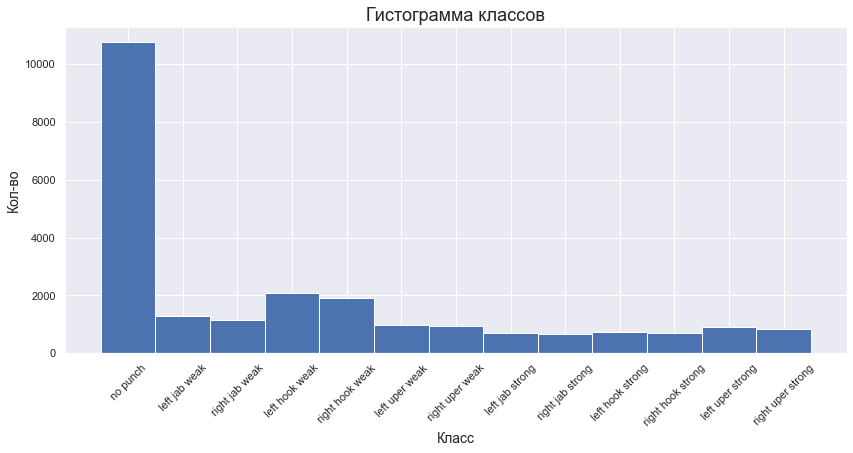

In [41]:
# Visualize y_train
sns.set_theme()

plt.hist(y_train, bins=[i - 0.5 for i in range(len(LABELS) + 1)])
plt.title('Гистограмма классов', fontsize=18)
plt.xlabel('Класс', fontsize=14)
plt.ylabel('Кол-во', fontsize=14)
plt.xticks([i for i in range(len(LABELS))], LABELS, rotation=45)
plt.savefig(BASE_DIR.joinpath('imgs', 'labels_train_hist.png'))
plt.show()

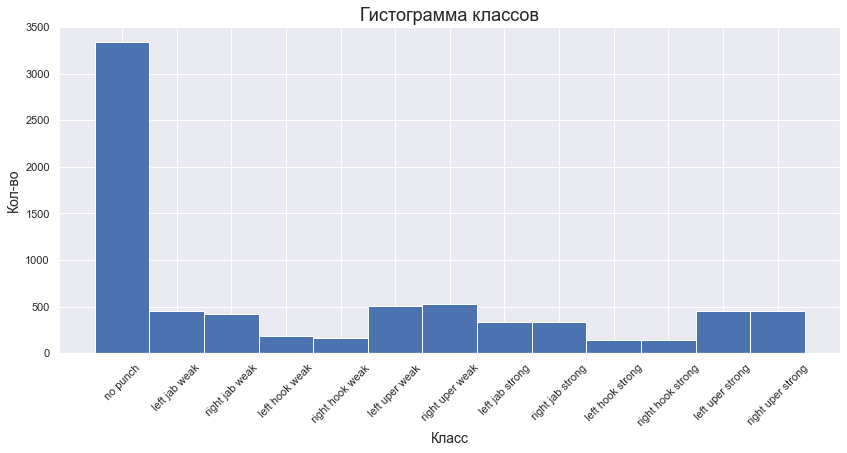

In [42]:
plt.hist(y_val, bins=[i - 0.5 for i in range(len(LABELS) + 1)])
plt.title('Гистограмма классов', fontsize=18)
plt.xlabel('Класс', fontsize=14)
plt.ylabel('Кол-во', fontsize=14)
plt.xticks([i for i in range(len(LABELS))], LABELS, rotation=45)
plt.savefig(BASE_DIR.joinpath('imgs', 'labels_val_hist.png'))
plt.show()

In [43]:
TIME_STEPS = 30 # expect camera 30 fps, so process 1 sample per second

# Number of samples in batch
N_train = X_train.shape[0] // TIME_STEPS
N_val = X_val.shape[0] // TIME_STEPS

X_train = X_train[:N_train * TIME_STEPS].reshape(-1, TIME_STEPS, 34)
y_train = y_train[:N_train * TIME_STEPS].reshape(-1, TIME_STEPS, 1)

X_val = X_val[:N_val * TIME_STEPS].reshape(-1, TIME_STEPS, 34)
y_val = y_val[:N_val * TIME_STEPS].reshape(-1, TIME_STEPS, 1)

In [44]:
X_val = X_val[:-3]
y_val = y_val[:-3]

print('X_train', X_train.shape)
print('y_train', y_train.shape)

print('X_val', X_val.shape)
print('y_val', y_val.shape)

X_train (788, 30, 34)
y_train (788, 30, 1)
X_val (244, 30, 34)
y_val (244, 30, 1)


In [45]:
y_train = K.utils.to_categorical(y_train, num_classes=13)
X_train = tf.constant(X_train)

y_val = K.utils.to_categorical(y_val, num_classes=13)
X_val = tf.constant(X_val)

## Simple RNN 

In [13]:
def get_model():
    return K.Sequential([
        K.layers.InputLayer((30, 34), batch_size=4),
        K.layers.LayerNormalization(axis=1),
        K.layers.SimpleRNN(128,
                           stateful=True,
                           return_sequences=True,
                           dropout=0.2,
                           recurrent_dropout=0.2),
        K.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)),
        K.layers.Dropout(0.2),
        K.layers.Dense(13, activation='softmax')
    ])

In [14]:
model = get_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization (LayerNo (4, 30, 34)               60        
_________________________________________________________________
simple_rnn (SimpleRNN)       (4, 30, 128)              20864     
_________________________________________________________________
dense (Dense)                (4, 30, 128)              16512     
_________________________________________________________________
dropout (Dropout)            (4, 30, 128)              0         
_________________________________________________________________
dense_1 (Dense)              (4, 30, 13)               1677      
Total params: 39,113
Trainable params: 39,113
Non-trainable params: 0
_________________________________________________________________


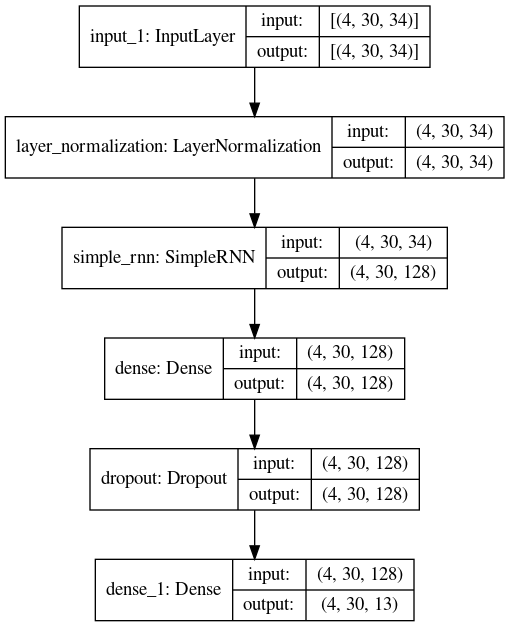

In [16]:
plot_model(model,
           to_file=BASE_DIR.joinpath('imgs', 'simple_rnn_test.png'),           
           show_shapes=True, show_layer_names=True)

In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=4, epochs=20, shuffle=False)

Epoch 1/20


2022-03-03 09:44:40.578682: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


197/197 [==============================] - 7s 36ms/step - loss: 2.0943 - accuracy: 0.4327 - val_loss: 2.6535 - val_accuracy: 0.4638
Epoch 2/20
197/197 [==============================] - 7s 34ms/step - loss: 1.9252 - accuracy: 0.4804 - val_loss: 2.3949 - val_accuracy: 0.3549
Epoch 3/20
197/197 [==============================] - 7s 34ms/step - loss: 1.8087 - accuracy: 0.4911 - val_loss: 2.4235 - val_accuracy: 0.4430
Epoch 4/20
197/197 [==============================] - 7s 34ms/step - loss: 1.7664 - accuracy: 0.5061 - val_loss: 2.2954 - val_accuracy: 0.3374
Epoch 5/20
197/197 [==============================] - 7s 34ms/step - loss: 1.7000 - accuracy: 0.5124 - val_loss: 2.2914 - val_accuracy: 0.3608
Epoch 6/20
197/197 [==============================] - 7s 34ms/step - loss: 1.6669 - accuracy: 0.5199 - val_loss: 2.2182 - val_accuracy: 0.3749
Epoch 7/20
197/197 [==============================] - 7s 34ms/step - loss: 1.6674 - accuracy: 0.5275 - val_loss: 2.1724 - val_accuracy: 0.3258
Epoch 8/20

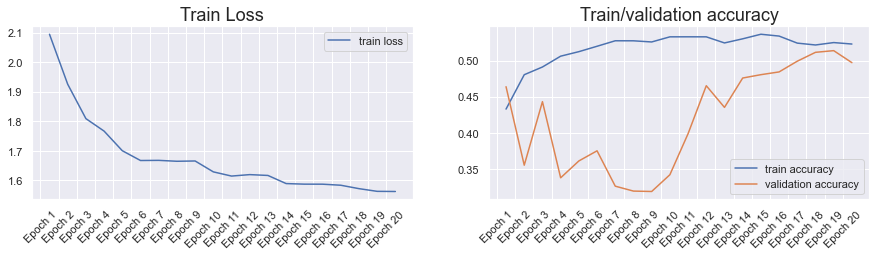

In [19]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title('Train Loss', fontsize=18)
plt.plot(history.history['loss'], label='train loss')
plt.xticks([i - 0.5 for i in range(len(history.history['loss']))],
           [f'Epoch {i + 1}' for i in range(len(history.history['loss']))], rotation=45)
plt.legend()
plt.subplot(222)
plt.title('Train/validation accuracy', fontsize=18)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xticks([i - 0.5 for i in range(len(history.history['loss']))],
           [f'Epoch {i + 1}' for i in range(len(history.history['loss']))], rotation=45)
plt.legend()
plt.savefig(BASE_DIR.joinpath('imgs', 'rnn_loss_and_acc.png'))
plt.show()

## LSTM

In [46]:
def get_model():
    return K.Sequential([
        K.layers.InputLayer((30, 34), batch_size=4),
        K.layers.LayerNormalization(axis=1),
        K.layers.LSTM(128,
                           stateful=True,
                           return_sequences=True,
                           dropout=0.2,
                           recurrent_dropout=0.2),
        K.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)),
        K.layers.Dropout(0.2),
        K.layers.Dense(13, activation='softmax')
    ])

In [47]:
model = get_model()

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization_3 (Layer (4, 30, 34)               60        
_________________________________________________________________
lstm_1 (LSTM)                (4, 30, 128)              83456     
_________________________________________________________________
dense_6 (Dense)              (4, 30, 128)              16512     
_________________________________________________________________
dropout_3 (Dropout)          (4, 30, 128)              0         
_________________________________________________________________
dense_7 (Dense)              (4, 30, 13)               1677      
Total params: 101,705
Trainable params: 101,705
Non-trainable params: 0
_________________________________________________________________


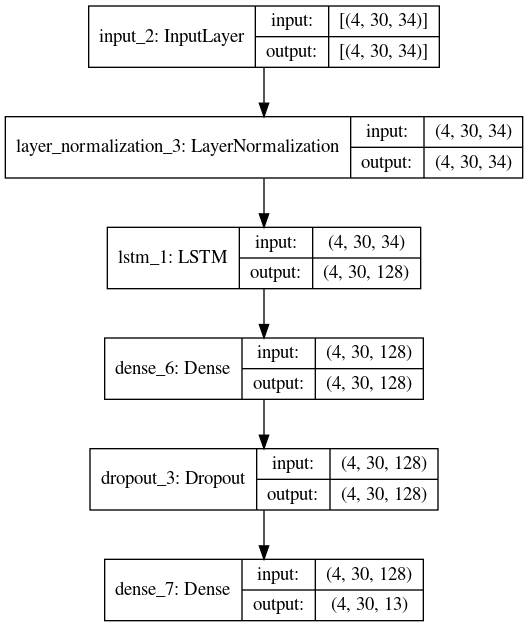

In [49]:
plot_model(model,
           to_file=BASE_DIR.joinpath('imgs', 'simple_lstm_test.png'),           
           show_shapes=True, show_layer_names=True)

In [50]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=4, epochs=20, shuffle=False)

Epoch 1/20
197/197 [==============================] - 13s 68ms/step - loss: 1.8816 - accuracy: 0.4927 - val_loss: 2.1115 - val_accuracy: 0.4589
Epoch 2/20
197/197 [==============================] - 14s 70ms/step - loss: 1.6354 - accuracy: 0.5456 - val_loss: 2.1524 - val_accuracy: 0.4109
Epoch 3/20
197/197 [==============================] - 13s 64ms/step - loss: 1.5803 - accuracy: 0.5626 - val_loss: 1.9167 - val_accuracy: 0.4653
Epoch 4/20
197/197 [==============================] - 13s 68ms/step - loss: 1.5061 - accuracy: 0.5728 - val_loss: 1.7997 - val_accuracy: 0.4862
Epoch 5/20
197/197 [==============================] - 13s 66ms/step - loss: 1.4449 - accuracy: 0.5844 - val_loss: 1.8018 - val_accuracy: 0.4869
Epoch 6/20
197/197 [==============================] - 11s 58ms/step - loss: 1.3955 - accuracy: 0.5997 - val_loss: 1.7504 - val_accuracy: 0.5034
Epoch 7/20
197/197 [==============================] - 13s 67ms/step - loss: 1.3508 - accuracy: 0.6097 - val_loss: 1.8249 - val_accuracy:

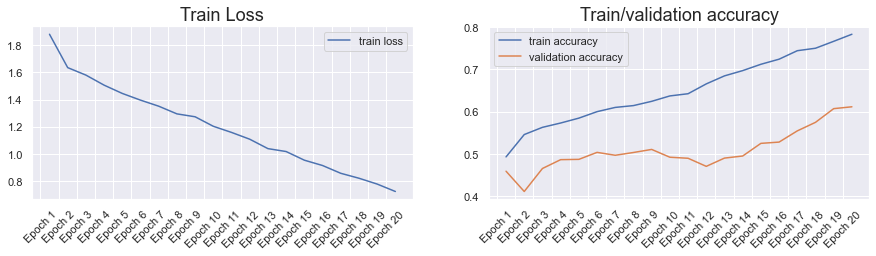

In [52]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title('Train Loss', fontsize=18)
plt.plot(history.history['loss'], label='train loss')
plt.xticks([i - 0.5 for i in range(len(history.history['loss']))],
           [f'Epoch {i + 1}' for i in range(len(history.history['loss']))], rotation=45)
plt.legend()
plt.subplot(222)
plt.title('Train/validation accuracy', fontsize=18)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xticks([i - 0.5 for i in range(len(history.history['loss']))],
           [f'Epoch {i + 1}' for i in range(len(history.history['loss']))], rotation=45)
plt.legend()
plt.savefig(BASE_DIR.joinpath('imgs', 'lstm_loss_and_acc.png'))
plt.show()

In [53]:
# Save LSTM model for testing purposes
model.save(BASE_DIR.joinpath('models', 'lstm_test_model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2022-03-04 10:36:18.700271: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/andrew/Рабочий стол/Punch_DL/models/lstm_test_model/assets


## GRU

In [27]:
def get_model():
    return K.Sequential([
        K.layers.InputLayer((30, 34), batch_size=4),
        K.layers.LayerNormalization(axis=1),
        K.layers.GRU(128,
                           stateful=True,
                           return_sequences=True,
                           dropout=0.2,
                           recurrent_dropout=0.2),
        K.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)),
        K.layers.Dropout(0.2),
        K.layers.Dense(13, activation='softmax')
    ])

In [28]:
model = get_model()

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization_2 (Layer (4, 30, 34)               60        
_________________________________________________________________
gru (GRU)                    (4, 30, 128)              62976     
_________________________________________________________________
dense_4 (Dense)              (4, 30, 128)              16512     
_________________________________________________________________
dropout_2 (Dropout)          (4, 30, 128)              0         
_________________________________________________________________
dense_5 (Dense)              (4, 30, 13)               1677      
Total params: 81,225
Trainable params: 81,225
Non-trainable params: 0
_________________________________________________________________


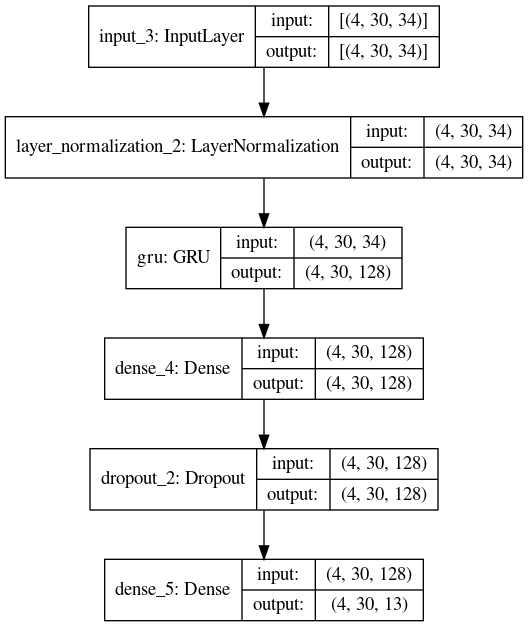

In [30]:
plot_model(model,
           to_file=BASE_DIR.joinpath('imgs', 'simple_gru_test.png'),           
           show_shapes=True, show_layer_names=True)

In [31]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=4, epochs=20, shuffle=False)

Epoch 1/20
197/197 [==============================] - 17s 84ms/step - loss: 2.0518 - accuracy: 0.4795 - val_loss: 2.4466 - val_accuracy: 0.3286
Epoch 2/20
197/197 [==============================] - 16s 80ms/step - loss: 1.7818 - accuracy: 0.5121 - val_loss: 2.2648 - val_accuracy: 0.4272
Epoch 3/20
197/197 [==============================] - 16s 81ms/step - loss: 1.6849 - accuracy: 0.5435 - val_loss: 2.0396 - val_accuracy: 0.3962
Epoch 4/20
197/197 [==============================] - 16s 82ms/step - loss: 1.5938 - accuracy: 0.5552 - val_loss: 1.9560 - val_accuracy: 0.4329
Epoch 5/20
197/197 [==============================] - 17s 86ms/step - loss: 1.5319 - accuracy: 0.5755 - val_loss: 1.8585 - val_accuracy: 0.4787
Epoch 6/20
197/197 [==============================] - 17s 84ms/step - loss: 1.4791 - accuracy: 0.5802 - val_loss: 1.8697 - val_accuracy: 0.4716
Epoch 7/20
197/197 [==============================] - 16s 81ms/step - loss: 1.4495 - accuracy: 0.5866 - val_loss: 1.7467 - val_accuracy:

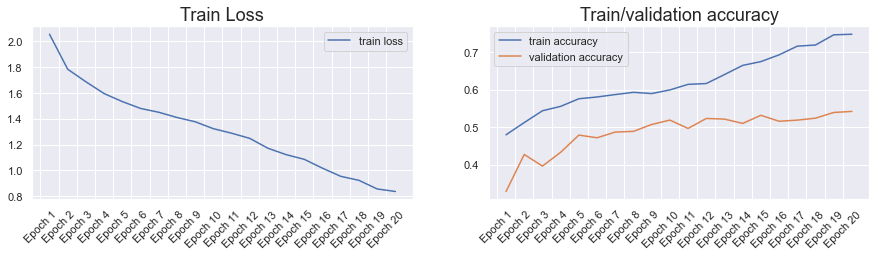

In [33]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title('Train Loss', fontsize=18)
plt.plot(history.history['loss'], label='train loss')
plt.xticks([i - 0.5 for i in range(len(history.history['loss']))],
           [f'Epoch {i + 1}' for i in range(len(history.history['loss']))], rotation=45)
plt.legend()
plt.subplot(222)
plt.title('Train/validation accuracy', fontsize=18)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xticks([i - 0.5 for i in range(len(history.history['loss']))],
           [f'Epoch {i + 1}' for i in range(len(history.history['loss']))], rotation=45)
plt.legend()
plt.savefig(BASE_DIR.joinpath('imgs', 'gru_loss_and_acc.png'))
plt.show()

## CNN

In [20]:
# Test `tf.keras.preprocessing.timeseries_dataset_from_array`
data = np.random.rand(20)
input_data = data[:-10]
targets = data[10:]
dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    input_data, targets, sequence_length=10)

for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:10])  # First sequence: steps [0-9]
    assert np.array_equal(targets[0], data[10])  # Corresponding target: step 10
    break

In [21]:
import os

class NoPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [23]:
class WindowGenerator():
    def __init__(self, input_width, shift, batch_size=1):
        X_train, y_train, X_val, y_val = self.get_data()

        self.X_train = X_train
        self.y_train = y_train
        
        self.X_val = X_val
        self.y_val = y_val

        # Window parameters.
        self.input_width = input_width
        self.shift = shift
        self.batch_size = batch_size
    
    @staticmethod
    def get_data():
        with NoPrints():
            X_train, y_train, X_val, y_val = get_train_data(skip_midpoints=True, all_labels=True)

        y_train = K.utils.to_categorical(y_train, num_classes=13)
        X_train = tf.constant(X_train)

        y_val = K.utils.to_categorical(y_val, num_classes=13)
        X_val = tf.constant(X_val)
        
        return X_train, y_train, X_val, y_val

    def make_dataset(self, inputs, targets):
        return K.preprocessing.timeseries_dataset_from_array(
            data=np.array(inputs[:-(self.input_width - 1)], dtype=np.float32),
            targets=np.array(targets[self.input_width - 1:], dtype=np.float32),
            sequence_length=self.input_width,
            sequence_stride=1,
            shuffle=False,
            batch_size=self.batch_size)
    
    @property
    def train(self):
        return self.make_dataset(self.X_train, self.y_train)

    @property
    def val(self):
        return self.make_dataset(self.X_val, self.y_val)

    def __repr__(self):
        return '\n'.join([
            f'Input width: {self.input_width}',
            f'Shift:       {self.shift}',
            f'Batch size:  {self.batch_size}'])

In [24]:
window_generator = WindowGenerator(input_width=10, shift=1)
print(window_generator)

Input width: 10
Shift:       1
Batch size:  1


In [25]:
def get_model():
    return K.Sequential([
        K.layers.Reshape((10, 34, 1), input_shape=(10, 34)),
        K.layers.LayerNormalization(axis=1),
        K.layers.Conv2D(13, (3, 3), activation='relu'),
        K.layers.Flatten(),
        K.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)),
        K.layers.Dropout(0.2),
        K.layers.Dense(13, activation='softmax')
    ])

In [26]:
model = get_model()

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 10, 34, 1)         0         
_________________________________________________________________
layer_normalization_1 (Layer (None, 10, 34, 1)         20        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 32, 13)         130       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3328)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               426112    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 13)               

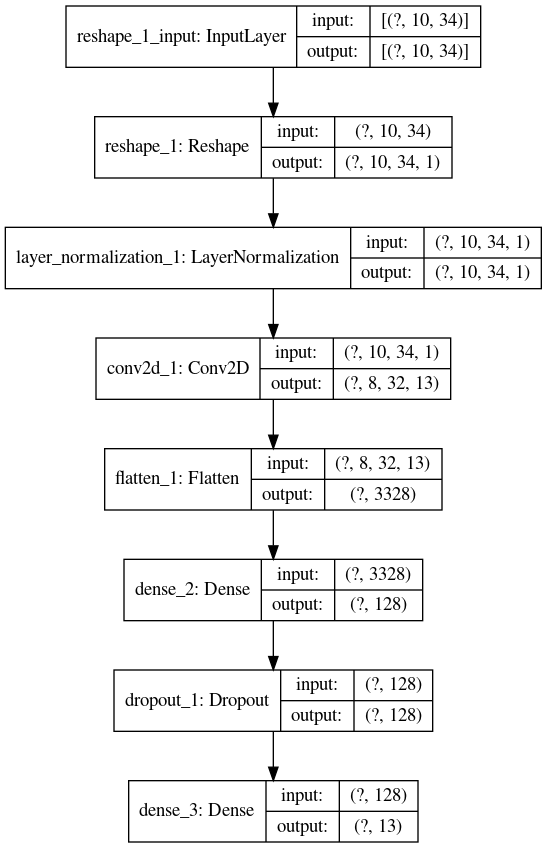

In [28]:
plot_model(model,
           to_file=BASE_DIR.joinpath('imgs', 'simple_cnn_test.png'),           
           show_shapes=True, show_layer_names=True)

In [29]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
history = model.fit(window_generator.train,
                    validation_data=(window_generator.val), batch_size=1, epochs=20, shuffle=False)

Epoch 1/20


2022-03-04 09:51:49.601493: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-03-04 09:51:49.913791: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


23624/23624 [==============================] - 84s 4ms/step - loss: 0.8696 - accuracy: 0.7723 - val_loss: 3.6380 - val_accuracy: 0.4233
Epoch 2/20
23624/23624 [==============================] - 86s 4ms/step - loss: 0.8463 - accuracy: 0.7736 - val_loss: 3.9922 - val_accuracy: 0.3747
Epoch 3/20
23624/23624 [==============================] - 88s 4ms/step - loss: 0.8552 - accuracy: 0.7682 - val_loss: 5.5237 - val_accuracy: 0.3373
Epoch 4/20
23624/23624 [==============================] - 90s 4ms/step - loss: 0.8576 - accuracy: 0.7645 - val_loss: 5.4038 - val_accuracy: 0.3940
Epoch 5/20
23624/23624 [==============================] - 93s 4ms/step - loss: 0.8855 - accuracy: 0.7580 - val_loss: 5.3907 - val_accuracy: 0.4005
Epoch 6/20
23624/23624 [==============================] - 93s 4ms/step - loss: 0.8734 - accuracy: 0.7624 - val_loss: 5.3641 - val_accuracy: 0.3450
Epoch 7/20
23624/23624 [==============================] - 94s 4ms/step - loss: 0.8693 - accuracy: 0.7659 - val_loss: 5.7639 - val

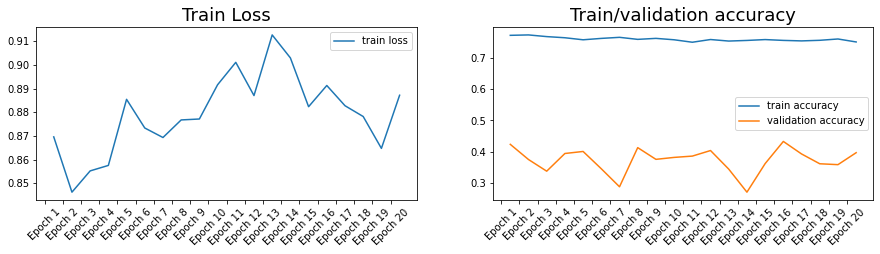

In [31]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title('Train Loss', fontsize=18)
plt.plot(history.history['loss'], label='train loss')
plt.xticks([i - 0.5 for i in range(len(history.history['loss']))],
           [f'Epoch {i + 1}' for i in range(len(history.history['loss']))], rotation=45)
plt.legend()
plt.subplot(222)
plt.title('Train/validation accuracy', fontsize=18)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xticks([i - 0.5 for i in range(len(history.history['loss']))],
           [f'Epoch {i + 1}' for i in range(len(history.history['loss']))], rotation=45)
plt.legend()
plt.savefig(BASE_DIR.joinpath('imgs', 'cnn_loss_and_acc.png'))
plt.show()